# Identifying Entities in Healthcare Data

## Workspace set up:
 Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

import re
from tqdm import tqdm
import collections
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
model = spacy.load("en_core_web_sm")

  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1896 sha256=d5b662dc1510d415547eac911849dbfd25b1e301dd89cc680316fda8c395a5fb
  Stored in directory: /root/.cache/pip/wheels/0b/68/37/a457e156cfd6174ed28c9c8cb76f18eeb559b760d84c0a22eb
Successfully built pycrf
     |████████████████████████████████| 743 kB 4.8 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

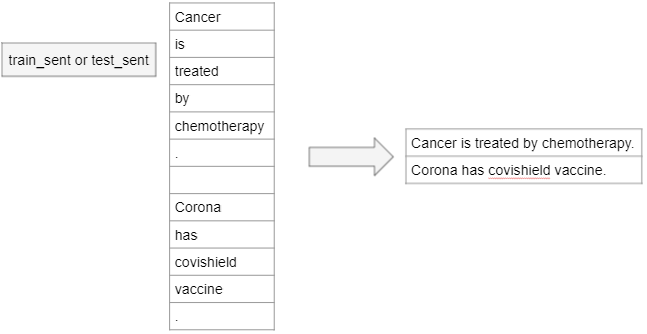

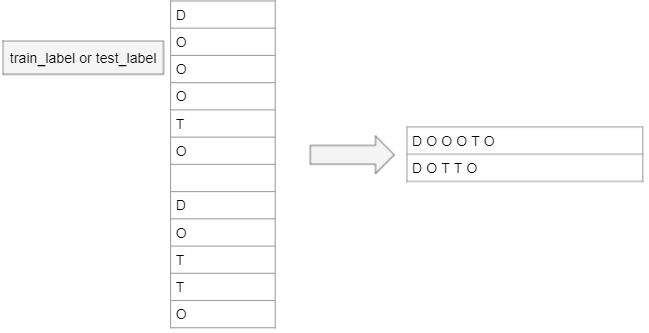

Read Training sentences and labels

In [2]:
#Read training data

#Sentences

with open('/content/train_sent') as f:
  train_sent= f.readlines()

#Labels

with open('/content/train_label') as f:
  train_label= f.readlines()

Read test sentences and labels

In [3]:
#Read test  data

#Sentences

with open('/content/test_sent') as f:
  test_sent= f.readlines()

#Labels

with open('/content/test_label') as f:
  test_label= f.readlines()

In [4]:
# A custom function to create sentences and labels from the files

def WordsToSent(input_list):
  output_list=[] #Initiate output list of sentences
  one_sent=[] #single sentence

  for i in range(len(input_list)):
    match=re.match('\n',input_list[i]) #blank line identifier

    if match:
      output_list.append(" ".join(e for e in one_sent)) #join all the words that appeared before the start of blank line
      one_sent=[] # re initialize the sentence to a blank list once blank line is noticed

    else:
      one_sent.append(input_list[i]) # collect all words for a sentence
  
  # Remove '\n' and replce by white space
  for sent_id in range(len(output_list)):
    output_list[sent_id]=re.sub('\n', '', output_list[sent_id])

  return output_list
    

In [5]:
#Training sentences and labels as list
training_sentences=WordsToSent(train_sent)
training_labels= WordsToSent(train_label)

#Test Sentences and labels as list
test_sentences= WordsToSent(test_sent)
test_labels = WordsToSent(test_label)

Print 5 sentences and their labels from training data

In [6]:
print("********* Training First five sentences and their labels ********")
i=0
max=5

while i<max:
  print("ID:",i)
  print("Sentence:\n",training_sentences[i])
  print("Label:\n", training_labels[i],"\n")
  i +=1

********* Training First five sentences and their labels ********
ID: 0
Sentence:
 All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label:
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O 

ID: 1
Sentence:
 The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label:
 O O O O O O O O O O O O O O O O O O O O O O O O O 

ID: 2
Sentence:
 Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label:
 O O O O O O O O O O O O O O O 

ID: 3
Sentence:
 The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label:
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

### Count the number of sentences in the processed train and test dataset 

In [7]:
print("Number of sentences in training dataset:", len(training_sentences))
print("Number of sentences in test dataset:", len(test_sentences))

Number of sentences in training dataset: 2599
Number of sentences in test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [8]:
print("Number of lines of labels in training dataset:", len(training_labels))
print("Number of lines of labels in test dataset:", len(test_labels))

Number of lines of labels in training dataset: 2599
Number of lines of labels in test dataset: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [9]:
def CollectCountNouns(input_list):
  noun_words=[]

  for sent in tqdm(input_list):

    doc=model(sent.lower())

    for token in doc:
           
      if token.pos_== 'NOUN' or token.pos_== 'PROPN':

        noun_words.append(token.text)

  # We have noticed that spacy model is collecting some non-alphanumeric symbols like '%' as noun
  noun_words= [element for element in noun_words if element.isalnum()]  #Collecting properwords

  #Get frequency of each word in a dictionary
  word_freq= collections.Counter(noun_words)

  #Sort by descending order of frequency
  word_freq= sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

  return word_freq

In [10]:
#Plot top 25 word


def barplot(word_freq):
  x_val=[word[0] for word in word_freq[0:25]]
  y_val=[freq[1] for freq in word_freq[0:25]]

  plt.figure(figsize=(12,8))
  plt.title("Top 25 most frequent Noun/Pronoun \n", size=20)
  sns.barplot(x=x_val, y=y_val)
  plt.ylabel("Frequency", size=16)
  plt.xticks(rotation=90)
  plt.show()


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

####Top 25 nouns in entire data

In [11]:
entire_data=training_sentences + test_sentences
entire_data_nouns=CollectCountNouns(entire_data)

#Top 25
print([word[0] for word in entire_data_nouns[0:25]])

100%|██████████| 3655/3655 [00:43<00:00, 84.92it/s]

['patients', 'treatment', 'cancer', 'therapy', 'study', 'disease', 'cell', 'lung', 'results', 'group', 'effects', 'gene', 'chemotherapy', 'use', 'effect', 'women', 'analysis', 'risk', 'surgery', 'cases', 'p', 'rate', 'survival', 'response', 'children']


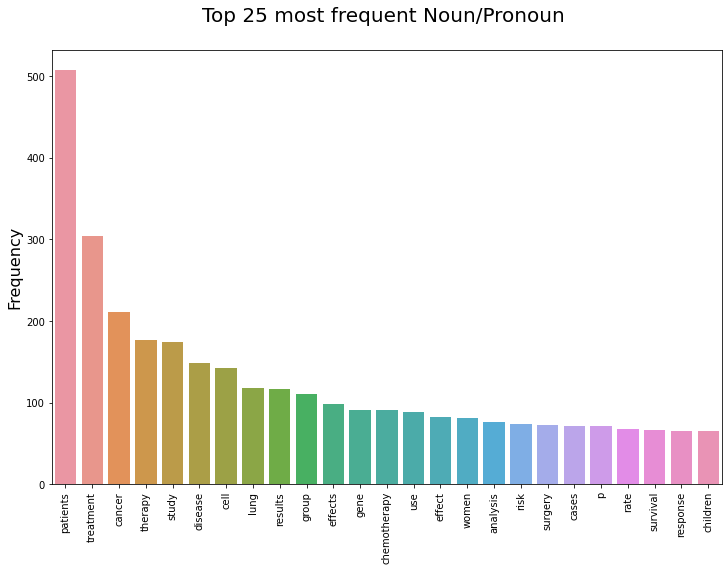

In [12]:
barplot(entire_data_nouns)

Observations:
- Nouns or pronouns are somewhat descriptive of disease (e.g. cancer) and treatment (e.g. chemo therapy), but not entirely

####Top 25 noun/pronoun in training

In [13]:
training_nouns= CollectCountNouns(training_sentences)
print([word[0] for word in training_nouns[0:25]])

100%|██████████| 2599/2599 [00:29<00:00, 89.09it/s]

['patients', 'treatment', 'cancer', 'therapy', 'study', 'disease', 'cell', 'lung', 'results', 'group', 'effects', 'chemotherapy', 'use', 'effect', 'gene', 'health', 'surgery', 'risk', 'women', 'survival', 'analysis', 'children', 'rate', 'care', 'cases']


#### Test data nouns

In [14]:
test_nouns= CollectCountNouns(test_sentences)
print([word[0] for word in test_nouns[0:25]])

100%|██████████| 1056/1056 [00:11<00:00, 89.25it/s]

['patients', 'treatment', 'cancer', 'therapy', 'study', 'cell', 'disease', 'group', 'results', 'gene', 'women', 'lung', 'effects', 'analysis', 'p', 'cases', 'effect', 'risk', 'use', 'response', 'chemotherapy', 'age', 'control', 'rate', 'surgery']


In [15]:
import pandas as pd
top25_enire_data=[word[0] for word in entire_data_nouns[0:25]]
top25_training=[word[0] for word in training_nouns[0:25]]
top25_test=[word[0] for word in test_nouns[0:25]]
            
pd.DataFrame({'Entire_Data':top25_enire_data, 'Training':top25_training, 'Test':top25_test})

,Entire_Data,Training,Test
0,patients,patients,patients
1,treatment,treatment,treatment
2,cancer,cancer,cancer
3,therapy,therapy,therapy
4,study,study,study
5,disease,disease,cell
6,cell,cell,disease
7,lung,lung,group
8,results,results,results
9,group,group,gene


We see top 25 most frequent noun / pronouns are more or less similar in entire data, training and test data

## Defining features for CRF






### Identification of distinct features

In order to understand the suitable features for determining tags of D and T, we look at following components:
- Word structure (i.e it start with captial letter , or a particular prefix or suffix etc.)
- PoS tags
- Dependency Tags
- Does it contain digit or special symbol
- Stop word etc.


In [16]:
# Collect sentence ids that contain at least one D or T tag in training
sent_id=[]
for id in range(len(training_labels)):
  match=re.search('D|T', training_labels[id])
  if match:
    sent_id.append(id)


In [17]:
training_sentences[sent_id[1]]

'All patients were managed by an intensified protocol , including stringent glycemic control'

In [18]:
training_labels[sent_id[1]]

'O O O O O O O O O O O T T'

In [19]:
# Collect different tokens for each word in a sentence
full_dict=dict()

for id in sent_id[0:5]:

  doc=model(training_sentences[id])

  word_dict=dict()

  word_dict['sentence_id']= [id]*len(training_labels[id].split()) # Sentence ID
  word_dict['label']=training_labels[id].split() #Label
  
  word_dict['text']=[token.text for token in doc] #Text
  word_dict['pos']=[token.pos_ for token in doc] # PoS tag
  word_dict['dep']=[token.dep_ for token in doc] #Dependency parsing tag
  word_dict['shape']=[token.shape_ for token in doc] #Shape
  word_dict['isalpha']=[token.is_alpha for token in doc] # Alpha numeric
  word_dict['isstop']=[token.is_stop for token in doc] #Stop words
  
  #merge with parent dictionary
  for key, values in word_dict.items():
    if key in full_dict:
      full_dict[key].extend(values)
    else:
      full_dict[key]=values



In [20]:
#Check tokens for words with D or T label
labels=['D','T']
df= pd.DataFrame(full_dict)
df= df.loc[df.label.isin(labels)]

df

,sentence_id,label,text,pos,dep,shape,isalpha,isstop
7,12,D,gestational,ADJ,amod,xxxx,True,False
8,12,D,diabetes,NOUN,pobj,xxxx,True,False
42,15,T,glycemic,ADJ,amod,xxxx,True,False
43,15,T,control,NOUN,pobj,xxxx,True,False
52,18,D,macrosomic,ADJ,compound,xxxx,True,False
53,18,D,infants,NOUN,pobj,xxxx,True,False
54,18,D,in,ADP,prep,xx,True,True
55,18,D,gestational,ADJ,amod,xxxx,True,False
56,18,D,diabetes,NOUN,compound,xxxx,True,False
57,18,D,cases,NOUN,pobj,xxxx,True,False


We note down few distinctive features of the words tagged as `D` or `T`:
- Such words are often comes together i.e occur as consecutive words
- Part of speech tag is either Noun/ Proper Noun or Adjective
- Dependency parsing tag of such words are often amod, pobj or compound
- In some cases these words often start with capital letter.
- Few words like syndrome , therapy etc. are quiet definitive indication of D or T label.

Features for our model: <br>
f1. A bias term (remove and check) <br>
f2: word in lower case <br>
f3: last 3 letetrs of the word (remove or increase to 4 /5 words) <br>
f4: if word is starting with an upper case <br>
f5: If word is digit (remove and check) <br>
f6: PoS tag of the word <br>
f7: Dependency parsing tag of the word <br>

In [21]:
# Write a code to get features for a sentence.
def getFeatureForOneWord(sentence, pos, postag, deppar):
  word= sentence[pos]
  features= {
  'bias':+ 1.0,
  'word.lower=': word.lower(),  #f1
  'word[-3:]=': word[-3: ], #f2
  'word[0].upper=': word[0].isupper(), #f3
  'word_is_digist=': word.isdigit(), #f4
  'word.postag=': postag[pos], #f5
  'word.dependency_parsing=': deppar[pos] #f6
  }

  if(pos>0):
    prev_word= sentence[pos-1]
    features.update({
    '-1:word.lower=': prev_word.lower(),  #f1
    '-1:word[-3:]=': prev_word[-3: ], #f2
    '-1:word[0].upper=': prev_word[0].isupper(), #f3  
    '-1:word_is_digist=':  word.isdigit(), #f4
    '-1:word.postag=': postag[pos-1],  #f5 
    '-1:word.dependency_parsing=': deppar[pos] #f6           
    })
  else:
    features['BEG']=True  #feature to track begin of a sequence

  if(pos== len(sentence)-1):
    features['END']=True #feature to track end of a sequence
  
  return features


## Getting the features

### Write a code/function to get the features for a sentence

In [22]:
def getFeatureForOneSentence(sentence):
  sentence_list= sentence.split()

  doc=model(sentence)
  postag=[token.pos_ for token in doc]
  deppar=[token.dep_ for token in doc]
 

  return [getFeatureForOneWord(sentence_list, pos, postag, deppar) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [23]:
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [24]:
# Write a code to get the labels for a sentence.
example_sentence= training_sentences[5]

print(example_sentence)

features = getFeatureForOneSentence(example_sentence)

features[4]



Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


{'-1:word.dependency_parsing=': 'compound',
 '-1:word.lower=': 'tertiary',
 '-1:word.postag=': 'ADJ',
 '-1:word[-3:]=': 'ary',
 '-1:word[0].upper=': False,
 '-1:word_is_digist=': False,
 'bias': 1.0,
 'word.dependency_parsing=': 'compound',
 'word.lower=': 'care',
 'word.postag=': 'NOUN',
 'word[-3:]=': 'are',
 'word[0].upper=': False,
 'word_is_digist=': False}

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [25]:
X_train = [getFeatureForOneSentence(sentence) for sentence in training_sentences]

X_test = [getFeatureForOneSentence(sentence) for sentence in test_sentences]


In [26]:
X_train[5]

[{'BEG': True,
  'bias': 1.0,
  'word.dependency_parsing=': 'amod',
  'word.lower=': 'cesarean',
  'word.postag=': 'ADJ',
  'word[-3:]=': 'ean',
  'word[0].upper=': True,
  'word_is_digist=': False},
 {'-1:word.dependency_parsing=': 'nsubjpass',
  '-1:word.lower=': 'cesarean',
  '-1:word.postag=': 'ADJ',
  '-1:word[-3:]=': 'ean',
  '-1:word[0].upper=': True,
  '-1:word_is_digist=': False,
  'bias': 1.0,
  'word.dependency_parsing=': 'nsubjpass',
  'word.lower=': 'rates',
  'word.postag=': 'NOUN',
  'word[-3:]=': 'tes',
  'word[0].upper=': False,
  'word_is_digist=': False},
 {'-1:word.dependency_parsing=': 'prep',
  '-1:word.lower=': 'rates',
  '-1:word.postag=': 'NOUN',
  '-1:word[-3:]=': 'tes',
  '-1:word[0].upper=': False,
  '-1:word_is_digist=': False,
  'bias': 1.0,
  'word.dependency_parsing=': 'prep',
  'word.lower=': 'at',
  'word.postag=': 'ADP',
  'word[-3:]=': 'at',
  'word[0].upper=': False,
  'word_is_digist=': False},
 {'-1:word.dependency_parsing=': 'amod',
  '-1:word.lo

### Define the labels as the target variable for test and the train dataset

In [27]:
Y_train = [getLabelsInListForOneSentence(sentence) for sentence in training_labels]

Y_test = [getLabelsInListForOneSentence(sentence) for sentence in test_labels]

## Build the CRF Model

In [28]:
# Build the CRF model
crf= sklearn_crfsuite.CRF(algorithm='lbfgs',
          c1=0.3,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)
crf.fit(X_train, Y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.3, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [29]:
Y_pred = crf.predict(X_test)


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [30]:
metrics.flat_f1_score(Y_test,Y_pred, average='weighted')

0.9190856557672034

In [31]:
print("Test sentence: \n",test_sentences[73])
print("Test Label: \n", Y_test[73])
print("Predicted label: \n", Y_pred[73])

Test sentence: 
 INTERPRETATION : Antichlamydial antibiotics may be useful in therapeutic intervention in addition to standard medication in patients with coronary-artery disease
Test Label: 
 ['O', 'O', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D']
Predicted label: 
 ['O', 'O', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

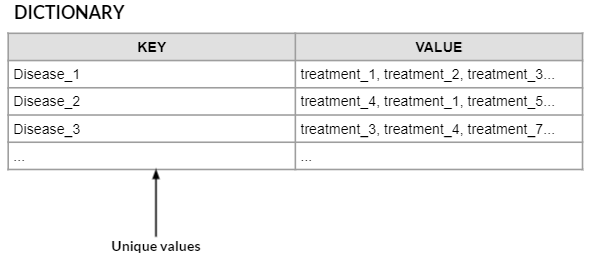

We assume that sentence that are having both treatment and disease label (i.e D and T) , the treatment is referring to disease only.

In [32]:
final=dict()

for id in range(len(test_sentences)):

  matchD=re.search('D{1,}', ''.join(Y_pred[id])) #match one or more labels of D
  matchT=re.search('T{1,}', ''.join(Y_pred[id])) #match one or more labels of T

  if matchD and matchT:   # Consider sentences having labels D and T both

    #ID.append(id)

    iterD= re.finditer('D{1,}',''.join(Y_pred[id]) ) #find substrings with one or more D
    iterT= re.finditer('T{1,}',''.join(Y_pred[id]) ) #find substrings with one or more T

    matchD_id=[(m.start(), m.end()) for m in iterD] #Collect start and end position of these substrings
    matchT_id=[(m.start(), m.end()) for m in iterT] #Collect start and end position of these substrings

    sent_split=test_sentences[id].split()

    for id in matchD_id:
      ds=' '.join(sent_split[id[0]:id[1]])  # Join words respective to these match positions
      #DS.append(ds)
      if ds not in final.keys(): # If the disease does not appear in previous search
        TRT=[]
        for id in matchT_id:
            trt=' '.join(sent_split[id[0]:id[1]]) # Join words respective to these match positions
            TRT.append(trt)

        final[ds]=TRT

      else: # If the disease is already appeared in previous search as key
        TRT=[]
        for id in matchT_id:
            trt=' '.join(sent_split[id[0]:id[1]]) # Join words respective to these match positions
            TRT.append(trt)
        final[ds]=TRT

   

Display few disease and their treatments as discovered by the above dictionary set up

In [38]:
pd.Series(final).rename_axis('Disease').reset_index(name='Treatment').head(10)

,Disease,Treatment
0,macrosomic infants in gestational diabetes cases,[good glycemic control]
1,microcephaly,[Trisomy]
2,nonimmune hydrops fetalis,[Trisomy]
3,cancer,[Matrix metalloproteinase inhibitors]
4,hereditary retinoblastoma,[radiotherapy]
5,epilepsy,[Methylphenidate]
6,unstable angina or non-Q-wave myocardial infar...,[roxithromycin]
7,coronary-artery disease,[Antichlamydial antibiotics]
8,pressure pain threshold,[cervical spine]
9,fenfluramines to primary pulmonary hypertensio...,[fenfluramines]


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [33]:
print("Treatment for heriditary retinoblastoma is" , ','.join(final['hereditary retinoblastoma']))

Treatment for heriditary retinoblastoma is radiotherapy
